In [1]:
# Importujemy odpowiednie biblioteki
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pathlib import Path

np.random.seed(42) # Uczyńmy wyniki notatnika stabilnymi w poszczególnych przebiegach

# Zdefiniujmy domyślne rozmiary czcionek służące do generowania ładnych rysunków
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Zdefiniujmy ustawienia biblioteki Pandas
pd.set_option('display.max_columns', None) # Wyświetlaj wszyskie kolumny w dataframe
# pd.set_option('display.max_rows', None) # Wyświetlaj wszyskie wiersze w dataframe
# pd.set_option(“display.max_colwidth”, None) # Maksymalna szerokość kolumny w dataframe. Może być liczbą (int) lub None (maksymalna szerokość)
# pd.set_option(‘display.precision’, 2) # Zdefiniuj precyzję wyświetlania liczb (float)
# pd.reset_option('display.max_columns') # Skopiuj i odkumnetuj, aby zresetować konkretną regułę tutaj 'max_columns'

In [2]:
datapath = Path() / "data" / "lifesat" # Definiujemy ścieżkę do bieżącego katalogu
# Wczytujey zbiory
oecd_bli = pd.read_csv(datapath / "oecd_bli.csv")
gdp_per_capita = pd.read_csv(datapath / "gdp_per_capita.csv")

In [3]:
oecd_bli

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.40,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.50,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.70,NaN,NaN
3,CAN,Canada,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,6.00,NaN,NaN
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,0.54,NaN,NaN
2365,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,32.09,NaN,NaN
2366,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,0.67,NaN,NaN
2367,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,WMN,Women,PC,Percentage,0,Units,NaN,NaN,19.37,NaN,NaN


In [ ]:
gdp_per_capita

In [6]:
gdp_per_capita.columns

Index(['Entity', 'Code', 'Year',
       'GDP per capita, PPP (constant 2017 international $)'],
      dtype='object')

In [8]:
# Wstępnie przetwarzamy dane PKB per capita tak, żeby był uwzględniany wyłącznie 2020 rok i uprośćmy nazwy kolumn
gdp_per_capita_2020 = gdp_per_capita[gdp_per_capita["Year"]==2020]
gdp_per_capita_2020 = gdp_per_capita_2020.rename(
    columns={
        "GDP per capita, PPP (constant 2017 international $)"
        : "GDP per capita (USD)"
    }
)
gdp_per_capita_2020

,Entity,Code,Year,GDP per capita (USD)
18,Afghanistan,AFG,2020,1978.961579
49,Africa Eastern and Southern,NaN,2020,3387.594670
80,Africa Western and Central,NaN,2020,4003.158913
111,Albania,ALB,2020,13295.410885
142,Algeria,DZA,2020,10681.679297
...,...,...,...,...
6984,Vanuatu,VUT,2020,2762.791388
7015,Vietnam,VNM,2020,8200.331867
7046,World,OWID_WRL,2020,16194.040310
7077,Zambia,ZMB,2020,3270.035112


In [9]:
# Poszukiwane przez nas zadowolenie z życia (Life satisfaction) to jedna z wartości w kolumnie 'Indicator'
oecd_bli["Indicator"].value_counts()

Indicator
Student skills                                       200
Self-reported health                                 182
Quality of support network                           168
Life satisfaction                                    168
Labour market insecurity                             162
Homicide rate                                        123
Feeling safe walking alone at night                  123
Life expectancy                                      123
Water quality                                        123
Employment rate                                      123
Years in education                                   120
Educational attainment                               120
Long-term unemployment rate                          117
Employees working very long hours                    117
Time devoted to leisure and personal care             69
Air pollution                                         41
Voter turnout                                         41
Stakeholder engagemen

In [10]:
# Dlatego musimy utworzyć tabelę przestawną (pivot table) z interesującymi nas wartościami
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(
    index="Country", 
    columns="Indicator", 
    values="Value"
)
oecd_bli

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3
Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5
Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1
Czech Republic,20.0,0.7,94.0,5.65,74.0,72.3,0.5,21453.0,NaN,24.0,3.1,79.1,6.7,1.04,25372.0,91.0,1.4,60.0,1.6,491.0,NaN,61.0,87.0,17.9
Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5


In [11]:
# Zresetujmy indeks, aby kraj był z powrotem kolumną. Przyda nam się to do łączenia tabel
oecd_bli = oecd_bli.reset_index()
oecd_bli

Indicator,Country,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
0,Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
1,Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
2,Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
3,Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
4,Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3
5,Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5
6,Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1
7,Czech Republic,20.0,0.7,94.0,5.65,74.0,72.3,0.5,21453.0,NaN,24.0,3.1,79.1,6.7,1.04,25372.0,91.0,1.4,60.0,1.6,491.0,NaN,61.0,87.0,17.9
8,Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5
9,Estonia,8.0,7.0,89.0,2.42,74.0,69.0,3.1,19697.0,159373.0,17.0,3.8,77.8,5.7,1.92,24336.0,92.0,1.6,53.0,2.7,524.0,14.90,64.0,84.0,17.7


In [12]:
# Wyświetlamy podstawowe informacje o dataframe
gdp_per_capita_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 18 to 7108
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entity                224 non-null    object 
 1   Code                  179 non-null    object 
 2   Year                  224 non-null    int64  
 3   GDP per capita (USD)  224 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.8+ KB


In [13]:
# Wyświetlamy podstawowe informacje o dataframe
oecd_bli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country                                            41 non-null     object 
 1   Air pollution                                      41 non-null     float64
 2   Dwellings without basic facilities                 38 non-null     float64
 3   Educational attainment                             40 non-null     float64
 4   Employees working very long hours                  39 non-null     float64
 5   Employment rate                                    41 non-null     float64
 6   Feeling safe walking alone at night                41 non-null     float64
 7   Homicide rate                                      41 non-null     float64
 8   Household net adjusted disposable income           30 non-null     float64
 9   Household ne

In [14]:
# Ponieważ kolumny "Country" i "Entity" są tego samego typu możemy zmergować tabele
full_country_stats = oecd_bli.merge(
    gdp_per_capita_2020, 
    left_on="Country", 
    right_on="Entity", 
    how="inner"
)
full_country_stats

,Country,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,Labour market insecurity,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Entity,Code,Year,GDP per capita (USD)
0,Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,5.4,82.5,7.3,1.31,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0,Australia,AUS,2020,48697.837028
1,Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,3.5,81.7,7.1,1.84,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0,Austria,AUT,2020,51935.603862
2,Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,3.7,81.5,6.9,3.54,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3,Belgium,BEL,2020,48210.033111
3,Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,NaN,74.8,6.4,NaN,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2,Brazil,BRA,2020,14063.982505
4,Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,6.0,81.9,7.4,0.77,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3,Canada,CAN,2020,45856.625626
5,Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,8.7,79.9,6.5,NaN,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5,Chile,CHL,2020,23324.524751
6,Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,NaN,76.2,6.3,0.79,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1,Colombia,COL,2020,13441.492952
7,Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,4.2,80.9,7.6,1.31,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5,Denmark,DNK,2020,55938.212809
8,Estonia,8.0,7.0,89.0,2.42,74.0,69.0,3.1,19697.0,159373.0,17.0,3.8,77.8,5.7,1.92,24336.0,92.0,1.6,53.0,2.7,524.0,14.90,64.0,84.0,17.7,Estonia,EST,2020,35638.421351
9,Finland,6.0,0.5,88.0,3.81,70.0,85.1,1.3,29943.0,200827.0,23.0,3.9,81.5,7.6,2.13,42964.0,95.0,1.9,70.0,2.2,523.0,15.17,67.0,95.0,19.8,Finland,FIN,2020,47260.800458


In [15]:
# Ograniczamy się do interesujących nas kolumn i sortujemy
full_country_stats = full_country_stats[[
    "Country", "Life satisfaction", "GDP per capita (USD)"
]]
full_country_stats = full_country_stats.sort_values(
    by="GDP per capita (USD)"
)
full_country_stats

,Country,Life satisfaction,GDP per capita (USD)
29,South Africa,4.7,11466.189672
6,Colombia,6.3,13441.492952
3,Brazil,6.4,14063.982505
21,Mexico,6.5,17887.750736
5,Chile,6.5,23324.524751
27,Russia,5.8,26456.387938
12,Greece,5.4,27287.083401
33,Turkey,5.5,28384.987785
18,Latvia,5.9,29932.493910
13,Hungary,5.6,31007.768407


Wyeksportujmy pełny zbiór `lifesat_full` do pliku

In [16]:
full_country_stats.to_csv(
    datapath / "lifesat_full.csv", 
    index=False
)

Oraz pomniejszony zbiór `lifesat` z PKB per capita mieszczącym się w przedziale pomiędzy `min_gdp` a `max_gdp`, który przez jakiś czas będziemy uznawać za nasz główny zbiór. Brakujące dane z pełnego zbioru wykorzystamy później do zaprezentowania jednego z problemów uczenia maszynowego.

In [ ]:
min_gdp = 23_500
max_gdp = 62_500
country_stats = full_country_stats[
    (full_country_stats["GDP per capita (USD)"] >= min_gdp) 
    & (full_country_stats["GDP per capita (USD)"] <= max_gdp)
]
country_stats.to_csv(
    datapath / "lifesat.csv", 
    index=False
)

Teraz wczytajmy utworzony plik `lifesat`

In [ ]:
# Wczytujemy dane
lifesat = pd.read_csv("data/lifesat/lifesat.csv")

# Przygotowujemy dane
lifesat.rename(
    columns={"GDP per capita (USD)": "PKB na mieszkanca (USD)"}, inplace=True
)
lifesat.rename(columns={"Life satisfaction": "Satysfakcja z zycia"}, inplace=True)
lifesat

,Country,Satysfakcja z zycia,PKB na mieszkanca (USD)
0,Russia,5.8,26456.387938
1,Greece,5.4,27287.083401
2,Turkey,5.5,28384.987785
3,Latvia,5.9,29932.493910
4,Hungary,5.6,31007.768407
5,Portugal,5.4,32181.154537
6,Poland,6.1,32238.157259
7,Estonia,5.7,35638.421351
8,Spain,6.3,36215.447591
9,Slovenia,5.9,36547.738956


A teraz zwizualizujmy dane

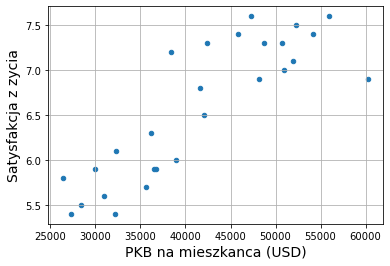

In [ ]:
# Wizualizujemy dane
lifesat.plot(kind='scatter', grid=True, 
             x="PKB na mieszkanca (USD)", y='Satysfakcja z zycia')
plt.show()

Pomimo że dane są **zaszumione** (tzn. częściowo losowe), wygląda
na to, że poziom satysfakcji z życia wzrasta w sposób mniej więcej liniowy wraz ze wzrostem produktu
krajowego brutto na osobę. Możemy zatem stworzyć model satysfakcji z życia jako funkcji
liniowej wobec parametru PKB per capita. Etap ten nazywamy **doborem modelu**: wybraliśmy **model
liniowy** satysfakcji z życia wykorzystujący tylko jeden atrybut — PKB na mieszkańca

Prosty model liniowy:
$$satysfakcja\ z\ zycia = \theta_0+\theta_1\cdot PKB\ na\ mieszkanca$$

Model ten zawiera dwa parametry, $\theta_0$ i $\theta_1$ (zgodnie z konwencją grecka litera $\theta$ (theta) często symbolizuje
parametry modelu). Poprzez modyfikowanie tych parametrów możemy za ich pomocą uzyskać dowolną funkcję liniową

Zanim zaczniemy korzystać z modelu, musimy zdefiniować wartości jego parametrów $\theta_0$ i $\theta_1$. Skąd
mamy wiedzieć, które wartości nadają się najlepiej dla danego modelu? Aby móc odpowiedzieć na to pytanie, należy zdefiniować miarę efektywności (jakości dopasowania). Możemy wyznaczyć **funkcję użyteczności** (zwaną także **funkcją dopasowania**), mówiącą nam, jak dobry jest dany model, lub **funkcję kosztu**, mającą przeciwne zastosowanie. W zagadnieniach wykorzystujących regresję liniową zazwyczaj jest stosowana funkcja kosztu mierząca kwadrat odległości pomiędzy przewidywaniami modelu liniowego, a przykładami uczącymi; naszym zadaniem jest zminimalizowanie tego dystansu.

W tym właśnie miejscu przydaje się algorytm regresji liniowej: dostarczamy mu dane uczące, a on
określa parametry najlepiej pasujące do danego modelu liniowego. Proces ten nosi nazwę uczenia
(trenowania) modelu.

Trenowanie modelu

In [ ]:
# Przygotowuje zmienne w modelu
X = lifesat[["PKB na mieszkanca (USD)"]]
y = lifesat[["Satysfakcja z zycia"]]

# Wybiera model liniowy
model = LinearRegression()

# Trenuje model
model.fit(X, y)

# Obliczone Współczynniki modelu
theta_0=model.intercept_[0]
theta_1=model.coef_[0][0]
print(f"theta_0: {theta_0}")
print(f"theta_1: {theta_1}")

theta_0: 3.74904942737691
theta_1: 6.778899694341219e-05


W naszym przykładzie algorytm regresji liniowej wyznacza następujące optymalne wartości parametrów: $\theta_0 = 3,75$ i $\theta_1 = 6,78·10^{-5}$. Teraz nasz model jest maksymalnie dopasowany do danych uczących (jak na model liniowy), o czym możemy się przekonać na poniższym rysunku

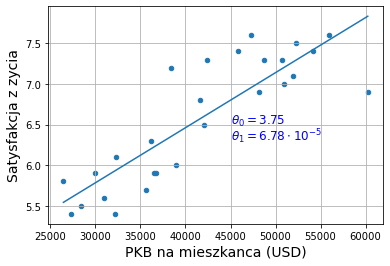

In [ ]:
# Wizualizujemy dane
lifesat.plot(kind='scatter', grid=True, 
             x="PKB na mieszkanca (USD)", y='Satysfakcja z zycia')
plt.plot(X, theta_0+theta_1*X)
plt.text(45000, 6.5, fr"$\theta_0 = {theta_0.round(2)}$", color="blue")
plt.text(45000, 6.3, fr"$\theta_1 = {theta_1 * 1e5:.2f}\cdot 10^{{-5}}$", color="blue")
plt.show()

Możemy w końcu uruchomić model, aby przeprowadził prognozy. Załóżmy na przykład, że chcemy się
dowiedzieć, jak szczęśliwi są Cypryjczycy. Informacji tej nie znajdziemy w bazie danych OECD. Ale
możemy się posłużyć modelem, aby uzyskać wiarygodne przewidywania: sprawdzamy wartość PKB per
capita dla Cypru:

In [ ]:
cyprus_gdp_per_capita_2020 = (
    gdp_per_capita_2020[gdp_per_capita_2020["Entity"]=="Cyprus"][["GDP per capita (USD)"]]
)
cyprus_gdp_per_capita_2020

,GDP per capita (USD)
1517,37655.180346


In [ ]:
cyprus_predicted_life_satisfaction = model.predict(cyprus_gdp_per_capita_2020)
cyprus_predicted_life_satisfaction

array([[6.30165633]])

Zastąpienie modelu regresji liniowej modelem k-najbliższych sąsiadów (np. dla k = 3) w poprzednim przykładzie sprowadza się do zastąpienia dwóch poniższych wierszy:

```python
from sklearn.linear_model import LinearRegression
model = LinearRegression()
```

tymi wierszami:

```python
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
```

In [ ]:
# Wybiera model regresji 3-najbliższych sąsiadów
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=3)

# Trenuje model_knn
model_knn.fit(X, y)

# Uzyskuje przewidywania dla Cypru
model_knn.predict(cyprus_gdp_per_capita_2020)


array([[6.33333333]])

Uzyskany wynik 6.(3) łatwo sprawdzić. Trzej najbliżsi sąsiedzi Cypru pod względem PKB na mieszkańca to Izrael, Litwa oraz Słowenia z wartościami Satysfakcji z życia odpowiednio 7.2, 5.9 oraz 5.9. Średnia arytmetyczna tych trzech wartości to właśnie:

In [ ]:
(7.2+5.9+5.9)/3

6.333333333333333